# Predicting Covid-19 Cases Using RNN GRU Model

This use-case provides a demo of how RNN and GRU can be used to model time series data. In our use-case, we will use Covid-19 data to predict the number of future cases based on the available historical data.

Workflow:


1.   Understanding the problem
2.   Collecting the data
3.   Data preprocessing
4.   Build Model using RNN & Grated Recurrent Unit (GRU)
5.   Training the dataset
6.   Predict


## 1. Understanding the problem
You have been given a dataset that has data of cases related to the spread of Covid-19 virus in India. We have to model the time series data using RNN GRU sequential model.

### Import the necessary libraries

We will use keras for this purpose. Please load the following packages before you proceed further.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt


from tensorflow.keras.layers import Dense, Dropout
from keras.layers import GRU
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## 2. Collecting the Data
It has been downloaded from the site https://www.kaggle.com/imdevskp/covid19-corona-virus-india-dataset


In [3]:
main_dataset1 = pd.read_csv("/kaggle/input/covid19-corona-virus-india-dataset/complete.csv") #Read the data

In [4]:
main_dataset1.head()

,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0


In [5]:
# Extracting date and total confirmed cases columns
date_column = 'Date'  # Assuming 'Date' is the column name for date
confirmed_cases_column = 'Total Confirmed cases'  # Assuming 'Total Confirmed cases' is the column name for confirmed cases

# Selecting only the columns of interest
main_dataset = main_dataset1[[date_column, confirmed_cases_column]]

# Displaying the selected data
print(main_dataset)

            Date  Total Confirmed cases
0     2020-01-30                    1.0
1     2020-01-31                    1.0
2     2020-02-01                    2.0
3     2020-02-02                    3.0
4     2020-02-03                    3.0
...          ...                    ...
4687  2020-08-06                73050.0
4688  2020-08-06                 5725.0
4689  2020-08-06               104388.0
4690  2020-08-06                 8254.0
4691  2020-08-06                83800.0

[4692 rows x 2 columns]


In [7]:
import warnings 
warnings.filterwarnings('ignore')

main_dataset['Total Confirmed cases'] = main_dataset['Total Confirmed cases'].astype(int)

In [8]:
main_dataset

,Date,Total Confirmed cases
0,2020-01-30,1
1,2020-01-31,1
2,2020-02-01,2
3,2020-02-02,3
4,2020-02-03,3
...,...,...
4687,2020-08-06,73050
4688,2020-08-06,5725
4689,2020-08-06,104388
4690,2020-08-06,8254


### Trend

In [9]:
main_dataset = main_dataset.rename(columns={'Total Confirmed cases': 'Cases'})

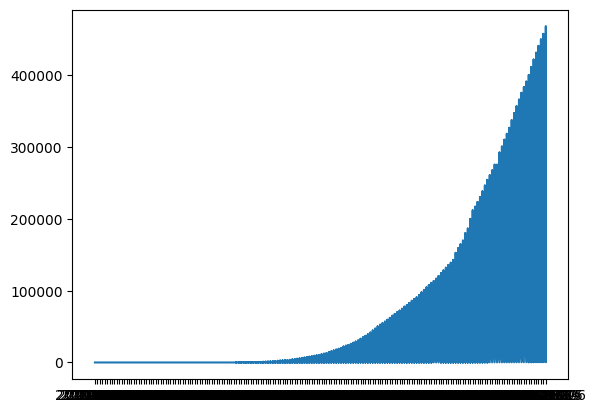

In [10]:
plt.plot(main_dataset.Date,main_dataset.Cases)
plt.show()

## 3. Data Preprocessing

We use following steps to preprocess the available dataset.

1.   Create new features from the available variables
2.   Create target and predictor datasets
3.   Scale the values in the datasets
4.   Get the datasets into desired format and shape.
5.   Split the dataset into train & test with appropriate ratio.



In [11]:
dataset = main_dataset #Create another dataset same as the main dataset. Just to avoid replacing the main one.
dataset = dataset.set_index('Date') #Set the index of the dataset as the date
dataset = dataset['Cases'] #We will be left with only one column Cases for our dataset

Create a new variable called Moving Average. Moving Average is a calculation of averages of subsequent datapoints. Example:





> 1-Jan-2010   100


> 2-Jan-2010   200







Moving average will be (200+100)/2 = 150

We will take moving average for 3 days in our example.

Note: You can create any number of such variables and any days.

In [12]:
dataset=dataset.to_frame() #Convert the Series into a dataframe object
dataset['Cases_MA2']=dataset.expanding(min_periods=3).mean()  #min_periods is used to set the no. of periods for calculating MA. Mean is for calculating average.

Create a new variable called Exponential Moving Average(EMA). EMA gives more weightage to the recent values rather than the old values. This could be handy in time series forecasting techniques.

We will take exponential moving average for 3 days in our example.

Note: You can create any number of such variables and any days.

In [13]:
dataset['EMA'] = dataset.iloc[:,0].ewm(span=3,adjust=False).mean() #ewm is used exponential moving average

In [14]:
dataset = dataset[dataset['Cases_MA2'].notna()] #Remove the rows that have NAs

Let's look at the dataset

In [15]:
dataset.head()

,Cases,Cases_MA2,EMA
Date,,,
2020-02-01,2,1.333333,1.50000
2020-02-02,3,1.750000,2.25000
2020-02-03,3,2.000000,2.62500
2020-02-04,3,2.166667,2.81250
2020-02-05,3,2.285714,2.90625


Here we will be predicting the column 'Cases'. Hence the target variable will be 'Cases'

In [16]:
#Cases is the column we have to predict.
target=dataset[['Cases']]
del dataset['Cases']

In [23]:
x, y = dataset.values, target.values

In [24]:
x.shape

(4655, 2)

In [25]:
y.shape

(4655, 1)

In [26]:
x_scaled_set = MinMaxScaler() #Use MinMaxScaler function from sklearn.preprocessing library
y_scaled_set = MinMaxScaler()

X = x_scaled_set.fit_transform(x) #Fit to data and transform the data array x
Y = y_scaled_set.fit_transform(y.reshape(-1,1)) #Fit to data and transform the data array y. Reshape the y variable to long format

In [27]:
x.shape

(4655, 2)

In [28]:
X_train_data=X[0:4000,]
y_train_data=Y[0:4000,]
X_test_data=X[4000:4690,]
y_test_data=Y[4000:4690,]

In [29]:
X_train_data.shape

(4000, 2)

In [30]:
y_test_data.shape

(655, 1)

In [31]:
X_train_data = X_train_data.reshape((-1,1,2)) #Reshape train dataset to required format
X_test_data = X_test_data.reshape((-1,1,2)) #Reshape test dataset to required format

## 4. Build Model using RNN & Grated Recurrent Unit (GRU)

In [32]:
GRU_model = Sequential() #Use Sequential function from keras.model library
GRU_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(1, 2))) #Add GRU model with 512 units. Note that return sequences should be true to pass on the sequences. Ensure that input_shape is inline with the inout data.
GRU_model.add(Dropout(0.2)) #Add a dropout layer to avoid overfitting.
GRU_model.add(GRU(units=256)) #Add another GRU layer with 256 units.
GRU_model.add(Dropout(0.2)) #Add another dropout layer to avoid overfitting.
GRU_model.add(Dense(1, activation='sigmoid')) #Finally, add a dense layer for getting a fully connected layer.


In [33]:
GRU_model.compile(loss='mse', optimizer='adam', metrics = ['accuracy']) #mse is mean square error which is the loss function and Adam optimizer will be the ooptimizer.

## 5. Training the Dataset

In [34]:
GRU_model.fit(X_train_data,y_train_data,batch_size=250, epochs=100, validation_split=0.15, verbose=1)
#GRU_model.save("covid_GRU.h5") #Save the model if you want for reuse.

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.0714 - loss: 0.2109 - val_accuracy: 0.0000e+00 - val_loss: 0.0307
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0785 - loss: 0.0341 - val_accuracy: 0.0000e+00 - val_loss: 0.0109
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0856 - loss: 8.1542e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0112
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0805 - loss: 5.9985e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0112
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0762 - loss: 7.2263e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0112
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.0790 - loss: 6.8510e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0112
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0790 - loss: 6.9973e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0112
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - ac

## 6. Predict

In [35]:
score = GRU_model.evaluate(X_test_data, y_test_data) #Evaluate model can be used to get the loss metric.
print('Score: {}'.format(score))
y_pred = GRU_model.predict(X_test_data) #Apply the built model on test data.
y_test_pred = y_scaled_set.inverse_transform(y_pred) #Use inverse transform to undo the scaling that was done before. This gives us the original values.
y_test_actual = y_scaled_set.inverse_transform(y_test_data) # Apply the inverse transform on the actual dataset for easy comparison of predicted vs actual.
#plt.plot(y_test_pred[-100:], label='Predicted') #Plot the predicted vs actual graph
#plt.plot(y_test_actual[-100:], label='Actual')
#plt.legend()
#plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 2.0982e-04 - loss: 0.0176
Score: [0.0249034333974123, 0.0015267175622284412]
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [36]:
test_Dates=main_dataset.Date[4000:4690] #create an object which has the dates for the Test data.

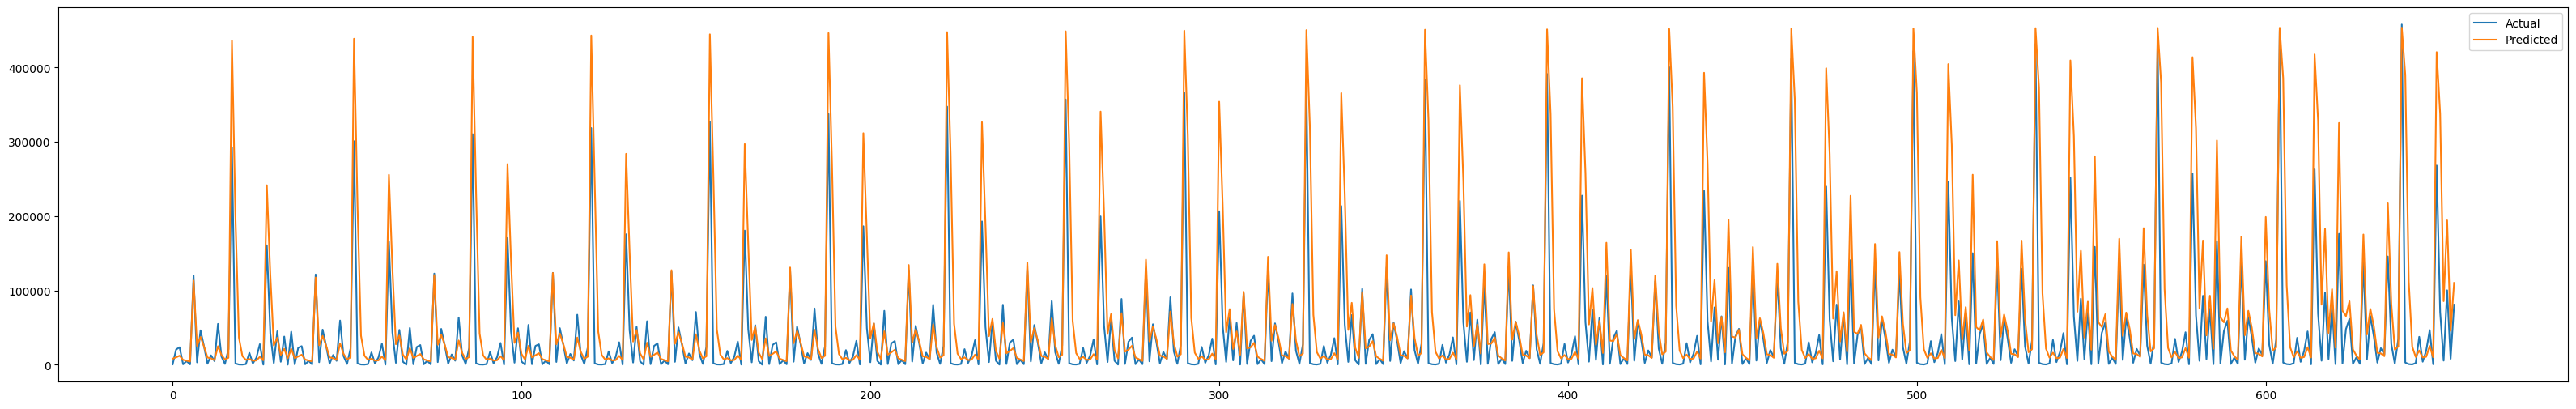

In [38]:

# Define the figure size
fig_size = (40, 6)  # Adjust width and height as needed

# Create a new figure with the specified size
plt.figure(figsize=fig_size)

# Assuming test_Dates, y_test_actual, and y_test_pred are already defined

# Plot actual and predicted data
plt.plot(y_test_actual, label='Actual')
plt.plot( y_test_pred, label='Predicted')

# Add legend
plt.legend()

# Show the plot
plt.show()




The mean square error (metric) is nearing zero. Analyzing the above graph, we see that our model was closely predicting for the 1st day. Though there are dip in cases after 20th April, our model predicted around 1600 cases. The cases saw a sudden spike which our model was able to predict very closely and maintained the trend till 27-April.